In [1]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AlignProcessor, AlignModel
import os
from util import *
from PIL import Image
import matplotlib.pyplot as plt

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, images_directory, description_path=None, transform=None):
        self.transform = transform
        self.data = []  # List of tuples (image_path, description, label)
        self.classes = []
        self.descriptions = []

        if description_path:
            descriptions = get_disease_skin_symptoms(description_path)
        else:
            descriptions = get_disease_skin_symptoms()

        subdirectories = os.listdir(images_directory)

        for key in descriptions.keys():
            self.classes.append(key)
            self.descriptions.append(descriptions[key])

        for subdirectory in subdirectories:
            subdirectory_path = os.path.join(images_directory, subdirectory)
            label = subdirectory

            for image in os.listdir(subdirectory_path):
                image_path = os.path.join(subdirectory_path, image)
                description = descriptions[label]
                self.data.append((image_path, description, label))

        print(f"Loaded {len(self.data)} images")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, description, label = self.data[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, description, label


transform = transforms.Compose([transforms.ToTensor()])

dataset = SkinDiseaseDataset(
    images_directory=get_train_image_directory(),
    transform=transform,
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Loaded 4010 images


In [3]:
def save_model(model, optimizer, model_path, optimizer_path):
    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)

In [4]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
model = AlignModel.from_pretrained("kakaobrain/align-base")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model.to(device)
#load_model(model, get_model_path(), optimizer, get_optimizer_path())

AlignModel(
  (text_model): AlignTextModel(
    (embeddings): AlignTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlignTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x AlignTextLayer(
          (attention): AlignTextAttention(
            (self): AlignTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): AlignTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
def align_loss_with_matrix(image_embeddings, text_embeddings, target_matrix):
    """
    Compute the binary cross entropy loss for align model given text and image embeddings and a target matrix.
    
    Parameters:
    text_embeddings (torch.Tensor): Text embeddings of shape (all_classes, embedding_dim)
    image_embeddings (torch.Tensor): Image embeddings of shape (batch_size, embedding_dim)
    target_matrix (torch.Tensor): Target matrix of shape (batch_size, all_classes), 
                                  where each entry is 1 if the pair is correct, 0 otherwise

    Returns:
    torch.Tensor: The computed loss
    """

    image_embeddings = F.normalize(image_embeddings, dim=1)
    text_embeddings = F.normalize(text_embeddings, dim=1)

    # Compute similarity matrix
    sim_matrix = torch.matmul(image_embeddings, text_embeddings.T)

    # Compute image-to-text classification loss
    loss_img_to_text = F.binary_cross_entropy_with_logits(sim_matrix, target_matrix)
    
    # Compute text-to-image classification loss
    loss_text_to_img = F.binary_cross_entropy_with_logits(sim_matrix.T, target_matrix.T)
    
    # Total loss
    loss = loss_img_to_text + loss_text_to_img
    return loss

In [ ]:
def align_loss_with_matrix(image_embeddings, text_embeddings, target_matrix):
    """
    Compute the mse loss for align model given text and image embeddings and a target matrix.
    
    Parameters:
    text_embeddings (torch.Tensor): Text embeddings of shape (all_classes, embedding_dim)
    image_embeddings (torch.Tensor): Image embeddings of shape (batch_size, embedding_dim)
    target_matrix (torch.Tensor): Target matrix of shape (batch_size, all_classes), 
                                  where each entry is 1 if the pair is correct, 0 otherwise

    Returns:
    torch.Tensor: The computed loss
    """
    # Normalize the embeddings
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
    image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.matmul(image_embeddings, text_embeddings.T)
    
    # Compute image-to-text loss
    loss_img_to_text = F.mse_loss(sim_matrix, target_matrix)

    # Compute text-to-image loss
    loss_text_to_img = F.mse_loss(sim_matrix.T, target_matrix.T)
    
    # Total loss
    loss = loss_img_to_text + loss_text_to_img
    
    return loss

In [5]:
def align_loss_with_matrix(image_embeddings, text_embeddings, target_matrix):
    """
    Compute the normalized softmax loss for the align model given text and image embeddings and a target matrix.
    
    Parameters:
    text_embeddings (torch.Tensor): Text embeddings of shape (all_classes, embedding_dim)
    image_embeddings (torch.Tensor): Image embeddings of shape (batch_size, embedding_dim)
    target_matrix (torch.Tensor): Target matrix of shape (batch_size, all_classes), 
                                  where each entry is 1 if the pair is correct, 0 otherwise
                                  
    Returns:
    torch.Tensor: The computed loss value
    """
    # Image-to-Text loss
    similarity_scores_image_to_text = torch.matmul(image_embeddings, text_embeddings.T)  # shape: (batch_size, all_classes)
    softmax_scores_image_to_text = F.softmax(similarity_scores_image_to_text, dim=1)  # shape: (batch_size, all_classes)
    log_probs_image_to_text = torch.log(softmax_scores_image_to_text + 1e-8)  # Add small value to avoid log(0)
    loss_image_to_text = -torch.sum(target_matrix * log_probs_image_to_text) / image_embeddings.size(0)
    
    # Text-to-Image loss
    similarity_scores_text_to_image = torch.matmul(text_embeddings, image_embeddings.T)  # shape: (all_classes, batch_size)
    softmax_scores_text_to_image = F.softmax(similarity_scores_text_to_image, dim=1)  # shape: (all_classes, batch_size)
    target_matrix_transposed = target_matrix.T
    log_probs_text_to_image = torch.log(softmax_scores_text_to_image + 1e-8)  # Adding small value to avoid log(0)
    loss_text_to_image = -torch.sum(target_matrix_transposed * log_probs_text_to_image) / text_embeddings.size(0)
    
    # Combined loss
    combined_loss = loss_image_to_text + loss_text_to_image
    
    return combined_loss

In [6]:
num_epochs = 2
losses = []
all_classes = dataset.classes
all_descriptions = dataset.descriptions

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, descriptions, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx+1}/{len(dataloader)}")

        # Matrix of correct indices of shape (batch_size, all_classes)
        target_matrix = torch.zeros(images.size(0), len(all_classes))
        for i, label in enumerate(labels):
            target_matrix[i][all_classes.index(label)] = 1
      
        optimizer.zero_grad()
        
        inputs = processor(
            text=all_descriptions, images=images, return_tensors="pt", padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        loss = align_loss_with_matrix(image_embeddings, text_embeddings, target_matrix)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Loss: {loss.item()}")
        losses.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")   
    save_model(model, optimizer, "../models/align-model-trained.pth", "../models/align-optimizer-trained.pth")

print("Finished training")

Epoch 1/2


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Batch 1/126
Loss: 8.50806713104248
Batch 2/126
Loss: 8.527641296386719
Batch 3/126
Loss: 8.491008758544922
Batch 4/126
Loss: 8.500370025634766
Batch 5/126
Loss: 8.50505256652832
Batch 6/126
Loss: 8.47878646850586
Batch 7/126
Loss: 8.472234725952148
Batch 8/126
Loss: 8.468562126159668
Batch 9/126
Loss: 8.451732635498047
Batch 10/126
Loss: 8.494771003723145
Batch 11/126
Loss: 8.471738815307617
Batch 12/126
Loss: 8.455409049987793
Batch 13/126
Loss: 8.465187072753906
Batch 14/126
Loss: 8.455036163330078
Batch 15/126
Loss: 8.452322006225586
Batch 16/126
Loss: 8.446983337402344
Batch 17/126
Loss: 8.43448257446289
Batch 18/126
Loss: 8.430420875549316
Batch 19/126
Loss: 8.411819458007812
Batch 20/126
Loss: 8.386598587036133
Batch 21/126
Loss: 8.401650428771973
Batch 22/126
Loss: 8.391768455505371
Batch 23/126
Loss: 8.398221015930176
Batch 24/126
Loss: 8.369352340698242
Batch 25/126
Loss: 8.353681564331055
Batch 26/126
Loss: 8.392471313476562
Batch 27/126
Loss: 8.34017276763916
Batch 28/126
Lo

In [7]:
# saving losses as json
with open("../models/align-base-skin-disease-losses-softmax.json", "w") as f:
    json.dump(losses, f)

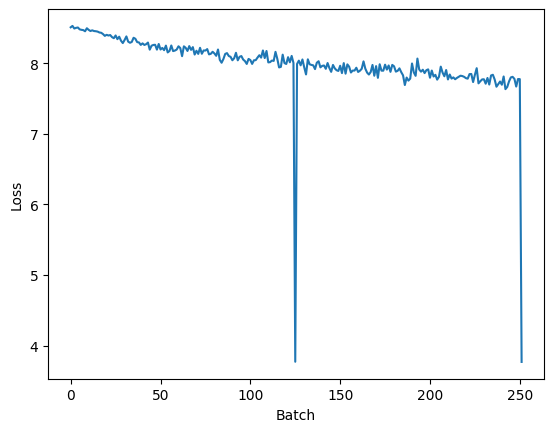

In [10]:
# plotting the losses
losses = read_json_file("../models/align-base-skin-disease-losses-softmax.json")

plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()